In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

Note: Use conda tf-gpu environment

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

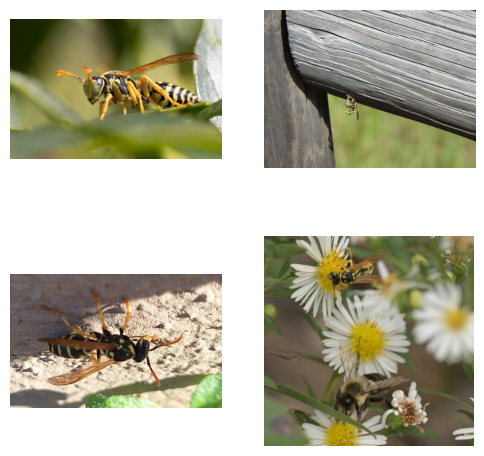

In [10]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [11]:
batch_size = 32

## B - <a name="generateurs"></a> Data Generators



In [12]:
seed = 42
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                    rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    brightness_range=(0.8, 1.2),
                                    fill_mode='nearest',
                                   )

val_data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                   )

- (d) Implement ```training_data```, ```valid_data``` splits


In [13]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = val_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)



Found 10989 images belonging to 127 classes.
Found 2726 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [14]:
# Model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches
#for layer in base_model.layers:
#    layer.trainable = False


"""
# Unfreeze the last N trainable convolutional blocks
trainable = False
for layer in reversed(base_model.layers):
    if 'conv' in layer.name:
        if N == 0:
            break
        N -= 1
        trainable = True
    layer.trainable = trainable
"""

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.3))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(127, activation='softmax'))

/tmp/ipykernel_1252802/3838958738.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)
I0000 00:00:1761049689.254779 1252802 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47179 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5
I0000 00:00:1761049689.255959 1252802 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45045 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:b6:00.0, compute capability: 7.5


In [15]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 12,
                                         mode = 'min',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [16]:
optimizer = Adam(learning_rate=0.0001) 

In [17]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [18]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [19]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau, early_stopping])

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1761049699.388494 1253074 service.cc:148] XLA service 0x74191c003360 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761049699.388517 1253074 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1761049699.388521 1253074 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-10-21 14:28:19.604980: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761049700.489271 1253074 cuda_dnn.cc:529] Loaded cuDNN version 91200
E0000 00:00:1761049702.232539 1253074 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761049702.356788 1253074 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. T

 76/344 ━━━━━━━━━━━━━━━━━━━━ 1:39 372ms/step - accuracy: 0.0199 - loss: 5.0290

E0000 00:00:1761049745.059622 1253074 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761049745.183191 1253074 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761049747.766164 1253074 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761049747.907145 1253074 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761049749.570673 1253074 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.0694 - loss: 4.5709

E0000 00:00:1761049873.134570 1253071 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761049873.258593 1253071 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761049875.799756 1253071 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761049875.942034 1253071 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/ho


Epoch 1: val_average_precision = 0.2759
344/344 ━━━━━━━━━━━━━━━━━━━━ 209s 540ms/step - accuracy: 0.1348 - loss: 4.0671 - val_accuracy: 0.2693 - val_loss: 3.0678 - val_average_precision: 0.2759 - learning_rate: 1.0000e-04
Epoch 2/30
344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.3339 - loss: 2.7779
Epoch 2: val_average_precision = 0.4182
344/344 ━━━━━━━━━━━━━━━━━━━━ 166s 482ms/step - accuracy: 0.3628 - loss: 2.5953 - val_accuracy: 0.4087 - val_loss: 2.3180 - val_average_precision: 0.4182 - learning_rate: 1.0000e-04
Epoch 3/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.4766 - loss: 2.0300
Epoch 3: val_average_precision = 0.4816
344/344 ━━━━━━━━━━━━━━━━━━━━ 163s 473ms/step - accuracy: 0.4763 - loss: 1.9897 - val_accuracy: 0.4527 - val_loss: 2.0940 - val_average_precision: 0.4816 - learning_rate: 1.0000e-04
Epoch 4/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5600 - loss: 1.6390
Epoch 4: val_average_precision = 0.5158
344/344 ━━━━━━━━━━━━━━━━━━━━ 165s 480ms/step - accuracy: 0.5564 - loss: 1.6338 - val_accuracy: 0.4897 - val_loss: 1.9333 - val_average_precision: 0.5158 - learning_rate: 1.0000e-04
Epoch 5/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.6149 - loss: 1.3845

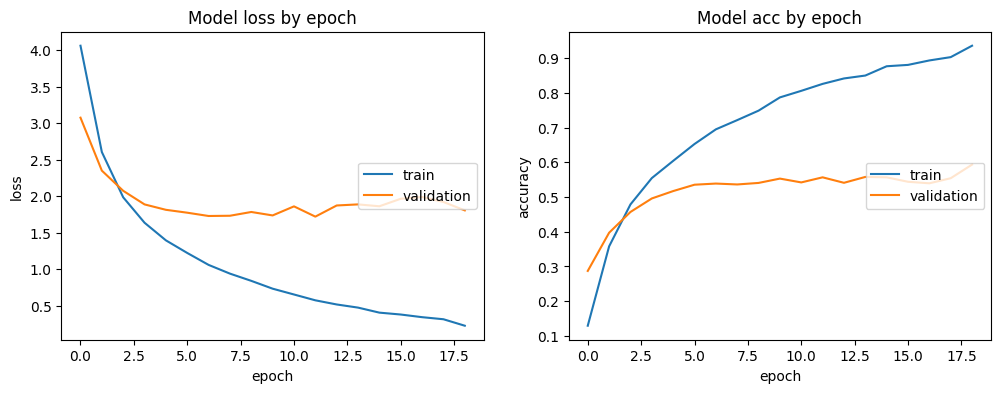

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [ ]:
model.save('../models/model_127_species_exp5.h5')